## Import modules

In [1]:
import os 

import mechanisms as mech
import graphsindy as gs

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

import sympy as sp

def symbolic_equations(A, x):
    """
    Given:
        A : np.ndarray of shape (M, N) with float entries
        x : np.ndarray of shape (N,) with variable names as strings (e.g. ["x_1","x_2",...])

    Returns:
        list of sympy expressions representing A * x
    """
    # Convert string variable names to sympy symbols
    sym_vars = sp.symbols(' '.join(x))

    # Create a sympy Matrix version of A and x
    A_sym = sp.Matrix(np.round(A,3))
    x_sym = sp.Matrix(sym_vars)

    # Compute the symbolic product
    y_sym = A_sym * x_sym

    # Pretty-print each resulting equation
    for i, expr in enumerate(y_sym):
        print(f"Equation {i}:")
        sp.pprint(expr, use_unicode=True)

    return y_sym

# Define a helper for blending two RGB triplets
def blend(c1, c2, w1=0.5, w2=0.5):
    c1 = np.array(c1)
    c2 = np.array(c2)
    mixed = w1*c1 + w2*c2
    return tuple(np.clip(mixed, 0, 1))  # keep values in [0, 1]

## Random seed for reproducibility

In [2]:
rng  = np.random.default_rng()
seed = rng.integers(1,10000)
print(f'Run seed:\n{seed}')

Run seed:
2050


## Model and simulation parameters

In [3]:
# Min-max values of fast and slow reactions
min_k, max_k = 5e-2, 1.0

# Choose model
model = 'M20'
#model = 'VdV'

In [4]:
if model == 'M20':
    constants = rng.uniform(min_k, max_k, size=6)
    Model = mech.M20(constants)
    w = 8

if model == 'VdV':
    #constants = rng.uniform(min_k, max_k, size=3)
    constants = [1e-3, 6.85e-3, 2.48e-3]
    Model = mech.VdV(constants)
    w = 4

print(f'Run kinetic rates:\n{constants}')
M, N = Model.M, Model.N
X_labels = Model.labels
C_ex  = Model.ExactCoeffMatrix()
K_ex  = Model.ExactKirchhoffMatrix()

initial_values = rng.uniform(0,1, size=(w, M))
rounded_values = np.round(initial_values, 3)
print(f'Run initial values:\n{rounded_values}')

# Simulation Parameters
tmax, npts = 20, 50                                       # Integration interval and No. of data points
t_eval = np.linspace(0,tmax,npts)                         # Equispaced data points
rtol = 1e-10                                              # Solve_IVP Tolerance (explore later)

# Noisy parameters
#noise_bool     = 'on'
#noise          = 1 / np.sqrt(N*w*npts)
#safe_smoothing = '1e-1'
#smoothing      = float(safe_smoothing)

# Denoised parameters
noise_bool = 'off'
noise      = 0.0
smoothing  = 0.0

print(f'Noise intensity:\n{noise}')

# STLS Threshold
threshold = np.min(constants)/2
print(f'STLS threshold:\n{threshold}')

Run kinetic rates:
[0.91060177 0.96249986 0.26105325 0.95365873 0.07834969 0.60168514]
Run initial values:
[[0.112 0.439 0.042 0.297 0.521 0.161]
 [0.826 0.072 0.804 0.593 0.388 0.6  ]
 [0.512 0.4   0.443 0.583 0.687 0.525]
 [0.196 0.467 0.142 0.852 0.381 0.473]
 [0.434 0.516 0.493 0.206 0.936 0.112]
 [0.534 0.818 0.736 0.355 0.963 0.796]
 [0.174 0.28  0.848 0.486 0.498 0.551]
 [0.464 0.467 0.504 0.509 0.092 0.169]]
Noise intensity:
0.0
STLS threshold:
0.03917484622849457


In [5]:
# Create/open directory for saving graph images
if noise_bool == "off":
    # Parent directory — shared by all runs of same model
    parent_folder = f"{model}_mechgrap_noise-{noise_bool}"
    os.makedirs(parent_folder, exist_ok=True)

    # Individual run directory
    run_folder = f"tmax-{tmax}_npts-{npts}"
    graphs_folder = os.path.join(parent_folder, run_folder)
    os.makedirs(graphs_folder, exist_ok=True)

if noise_bool == "on":
    # Parent directory — shared by all runs of same model
    parent_folder = f"{model}_mechgrap_noise-{noise_bool}"
    os.makedirs(parent_folder, exist_ok=True)
    
    # Individual run directory
    run_folder = f"tmax-{tmax}_npts-{npts}_smoothing-{safe_smoothing}"
    graphs_folder = os.path.join(parent_folder, run_folder)
    os.makedirs(graphs_folder, exist_ok=True)

## Simulation and interpolation

In [6]:
# Simulation
X = np.zeros((M,0)) 
T     = np.zeros((0,))
for i in range(w):
    sol   = integrate.solve_ivp(fun=lambda t,U: gs.matrix_ODE(t,U,C_ex), t_span=t_eval[[0,-1]], 
                                y0=initial_values[i], t_eval=t_eval, rtol=rtol)
    # Add noise to the simulation data
    for j in range(M):
        xi = rng.uniform(-noise, noise, size=sol.y[j].shape[0])
        sol.y[j] += xi
    X = np.hstack((X, sol.y))
    T = np.hstack((T, sol.t))

In [7]:
# Build dictionary matrix
D, D_labels = gs.build_dictionary(X_labels, X)
rankD  = np.linalg.matrix_rank(D)
if rankD == D.shape[0]:
    print(f'Dictionary of full row rank ({rankD})')

# Construct integration and differentiation operator matrices
spline_deg  = 3
spline_type = 'not-a-knot'
J,L         = gs.build_int_dif_matrix(t_eval, w, spline_deg, spline_type) #, smoothing)

# Construct IVP matrix
IVP = gs.build_ivp_matrix(npts,X)               

# Approximate the integral of dictionary matrix 
D_int  = D@J
rankDJ = np.linalg.matrix_rank(D_int)
if rankDJ == D_int.shape[0]:
    print(f'Integrated dictionary of full row rank ({rankDJ})')
    
X_int = C_ex@D_int         # Integral Formulation (Approximated from the data)
X_0   = X-IVP        # Integral formulation left-hand side Y_int_ex = CDK (Exact from the data)

Dictionary of full row rank (27)
Integrated dictionary of full row rank (27)


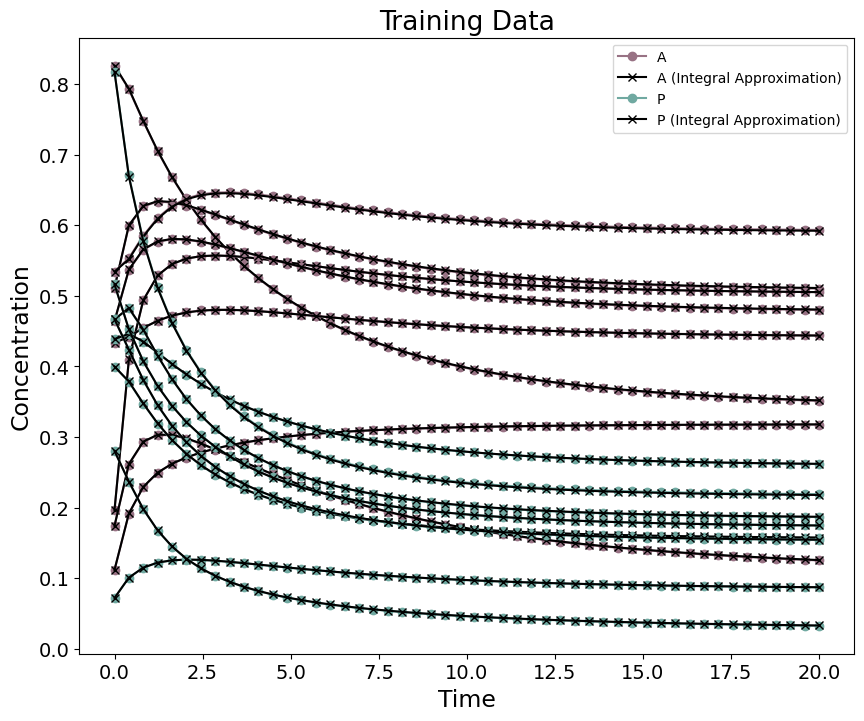

In [8]:
# Array of RGB colors in 0-255 range
rgb_colours = [(152, 114, 132),
              (112, 169, 161), 
              (166, 52, 70),
              (216, 30, 91),
              (20, 50, 60),
              (0, 0, 0)]

# Convert to 0-1 range
colours = [(r/255, g/255, b/255) for r, g, b in rgb_colours]

node_colours =  {'$x_{cat}$'      : np.array(colours[2]),
                 '$x_{catA}$'     : np.array(colours[3]),
                 '$x_{cat}x_{A}$' : np.array(colours[3]+colours[0]),
                 '$x_{cat}x_{P}$' : np.array(colours[3]+colours[1])
               }

plt.rcParams["figure.figsize"] = (10,8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in range(2):
    for j in range(w):
        if j == 0:
            ax1.plot(T[:npts], X[i][:npts].T, '-o', label=D_labels[i], color=colours[i])
            ax1.plot(T[:npts], IVP[i][:npts].T + X_int[i][:npts].T,   'k-x', label=D_labels[i] + ' (Integral Approximation)')
        else:
            ax1.plot(T[:npts], X[i][j*npts:(j+1)*npts].T, '-o', color=colours[i])
            ax1.plot(T[:npts], IVP[i][j*npts:(j+1)*npts].T + X_int[i][j*npts:(j+1)*npts].T, 'k-x')
            
plt.legend(fontsize=10)
plt.title('Training Data', fontsize = 19)
plt.ylabel('Concentration', fontsize = 17)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

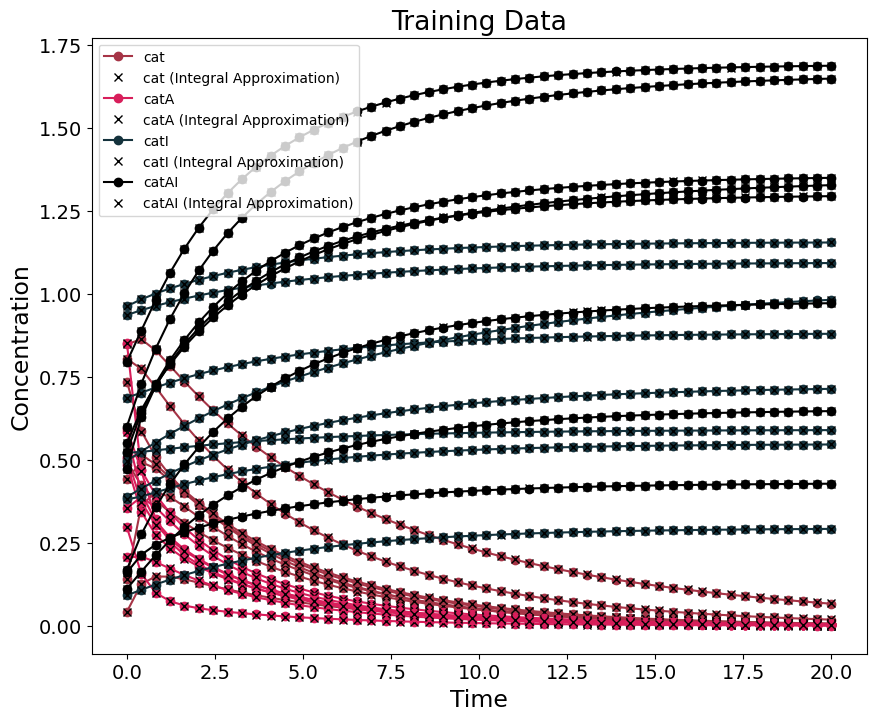

In [9]:
plt.rcParams["figure.figsize"] = (10,8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in range(M-2):
    for j in range(w):
        if j == 0:
            ax1.plot(T[:npts], X[i+2][:npts].T, '-o', label=D_labels[i+2], color=colours[i+2])
            ax1.plot(T[:npts], IVP[i+2][:npts].T + X_int[i+2][:npts].T,   'kx', label=D_labels[i+2] + ' (Integral Approximation)')
        else:
            ax1.plot(T[:npts], X[i+2][j*npts:(j+1)*npts].T, '-o', color=colours[i+2])
            ax1.plot(T[:npts], IVP[i+2][j*npts:(j+1)*npts].T + X_int[i+2][j*npts:(j+1)*npts].T, 'kx')
            
plt.legend(fontsize=10)
plt.title('Training Data', fontsize = 19)
plt.ylabel('Concentration', fontsize = 17)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Model recovery

In [10]:
C_dif = gs.itls(D,X@L, threshold)
C_int = gs.itls(D_int,X_0, threshold)

print(np.linalg.norm(C_ex - C_int, 2))
print(np.linalg.norm(C_ex - C_dif, 2))

0.015938553907191528
1.6678979147246786


In [11]:
C_int_red, Q, Q_labels = gs.reduce_model(C_int,M,N,D_labels)

C_dif_red, QQ, QQ_labels = gs.reduce_model(C_dif,M,N,D_labels)

C_ex_red, _ = gs.remove_zero_columns(C_ex)

print("The reduced identified coefficient matrix is:")
print(C_int_red)
print('\n')
#print("The reduced identified coefficient matrix is:")
#print(C_dif_red)
#print('\n')
print("The reduced exact coefficient matrix is:")
print(C_ex_red)

The reduced identified coefficient matrix is:
[[ 0.          0.9630802  -0.91129268  0.        ]
 [ 0.          0.26020919  0.         -0.95200853]
 [-0.07864594  1.21743731 -0.90739659 -0.94716612]
 [ 0.         -1.81652944  0.90648699  0.94538731]
 [ 0.0783556   0.          0.          0.        ]
 [ 0.          0.60154282  0.          0.        ]]


The reduced exact coefficient matrix is:
[[ 0.          0.96249986 -0.91060177  0.        ]
 [ 0.          0.26105325  0.         -0.95365873]
 [-0.07834969  1.22355311 -0.91060177 -0.95365873]
 [ 0.         -1.82523825  0.91060177  0.95365873]
 [ 0.07834969  0.          0.          0.        ]
 [ 0.          0.60168514  0.          0.        ]]


## Graph recovery

### Attempt 1: C_int filtration routine 1

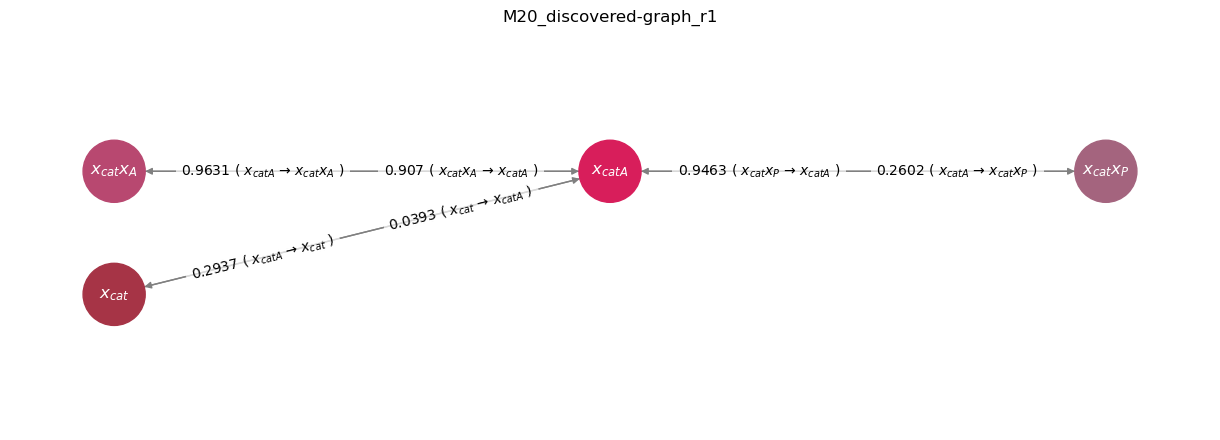

In [12]:
K_opt = gs.solve_kirchhoff(Q, C_int_red)
K_opt = np.where(np.abs(K_opt) >= threshold, K_opt, 0)

#print("The Kirchhoff matrix found by optimization is:")
#print(Q_labels)
#print(K_opt)

if model == 'VdV':
    graph_labels = ['$x_{1}$', 
                    '$x_{3}$', 
                    '$x_{1}x_{1}$'
                   ]
    
    positions = {'$x_{1}$'      : (3.0, 0.0),
                 '$x_{3}$'      : (0.0, 0.0),
                 '$x_{1}x_{1}$' : (6.0, 0.0)
                }
    
    node_colours = {'$x_{1}$'    : np.array(colours[0]), 
                    '$x_{3}$'    : np.array(colours[2]), 
                    '$x_{1}x_{1}$': np.array(blend(colours[0], colours[0]))
                    }
    size         = (10, 1)



if model == 'M20':
    graph_labels = ['$x_{cat}$',
                    '$x_{catA}$',
                    '$x_{cat}x_{A}$',
                    '$x_{cat}x_{P}$'
                   ]
    
    positions =  {'$x_{cat}$'     : (0, 0),
                  '$x_{catA}$'    : (0.5, 0.005),
                  '$x_{cat}x_{A}$': (0, 0.005),
                  '$x_{cat}x_{P}$': (1.0, 0.005)
                  }

    node_colours = {'$x_{cat}$'      : np.array(colours[2]),
                    '$x_{catA}$'     : np.array(colours[3]),
                    '$x_{cat}x_{A}$' : np.array(blend(colours[3], colours[0])),
                    '$x_{cat}x_{P}$' : np.array(blend(colours[3], colours[1]))
                    }
    size         = (12, 4)


gs.draw_directed_graph_from_kirchhoff(-K_opt.T,
                                      labels       = graph_labels,
                                      title        = model + "_discovered-graph_r1",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

In [13]:
print('Ground truth ODE')
Eq_ex = symbolic_equations(C_ex, np.asarray(D_labels).T)
print('\n')
print('Model recovery ODE')
Eq_int = symbolic_equations(C_int, np.asarray(D_labels).T)
print('\n')
print('Graph recovery ODE')
Eq_int_K = symbolic_equations(Q @ K_opt, np.asarray(Q_labels).T)

Ground truth ODE
Equation 0:
-0.911⋅cat*A + 0.962⋅catA
Equation 1:
-0.954⋅cat*P + 0.261⋅catA
Equation 2:
-0.078⋅cat - 0.911⋅cat*A - 0.954⋅cat*P + 1.224⋅catA
Equation 3:
0.911⋅cat*A + 0.954⋅cat*P - 1.825⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Model recovery ODE
Equation 0:
-0.911⋅cat*A + 0.963⋅catA
Equation 1:
-0.952⋅cat*P + 0.26⋅catA
Equation 2:
-0.079⋅cat - 0.907⋅cat*A - 0.947⋅cat*P + 1.217⋅catA
Equation 3:
0.906⋅cat*A + 0.945⋅cat*P - 1.817⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Graph recovery ODE
Equation 0:
-0.911⋅cat*A + 0.963⋅catA
Equation 1:
-0.952⋅cat*P + 0.26⋅catA
Equation 2:
-0.039⋅cat - 0.911⋅cat*A - 0.952⋅cat*P + 1.517⋅catA
Equation 3:
0.039⋅cat + 0.907⋅cat*A + 0.946⋅cat*P - 1.517⋅catA
Equation 4:
0
Equation 5:
0


### Attempt 2: C_int filtration routine 1 with added zero-complex

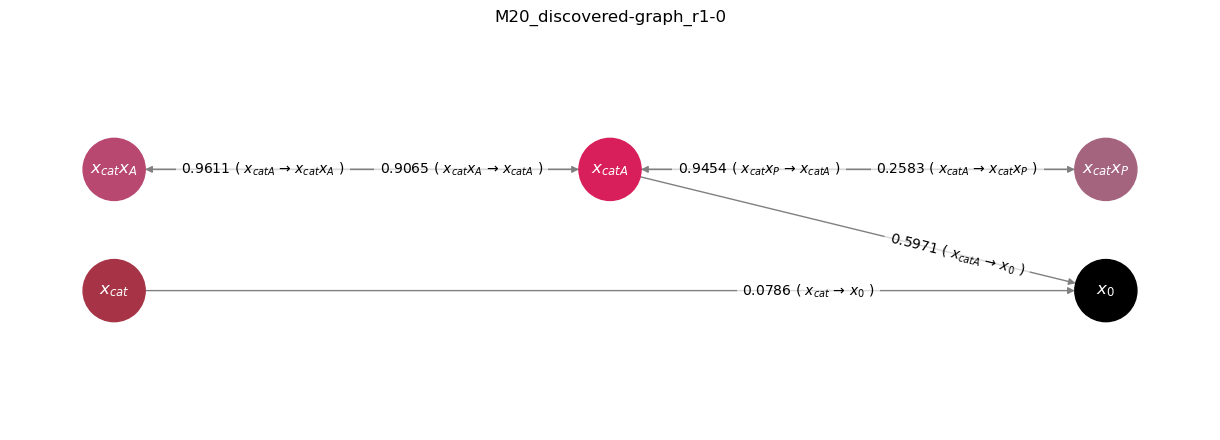

In [14]:
# Add zero-complex to SINDy discovered ODE
# Horizontally stack a 0 M-vector to the MxN discovered coefficient matrix
C_int_red_0 = np.hstack((C_int_red,np.zeros((M, 1))))

# Horizontally stack a 0 M-vector to the MxM inferred complexes matrix
Q_0 = np.hstack((Q,np.zeros((M, 1))))

#print(C_int_red_0)
#print('\n')
#print(Q_0)

K_opt_0 = gs.solve_kirchhoff(Q_0, C_int_red_0)
K_opt_0 = np.where(np.abs(K_opt_0) >= threshold, K_opt_0, 0)

#print("The Kirchhoff matrix found by optimization (with zero-complex) is:")

if model == 'VdV':
    graph_labels = ['$x_{1}$', 
                    '$x_{3}$', 
                    '$x_{1}x_{1}$',
                    '$x_{0}$'
                   ]
    
    positions = {'$x_{1}$'      : (1, 0),
                 '$x_{3}$'      : (0, 0),
                 '$x_{1}x_{1}$' : (2, 0),
                 '$x_{0}$'      : (1, 0.05)
                 
                }
    
    node_colours = {'$x_{1}$'     : np.array(colours[0]), 
                    '$x_{3}$'     : np.array(colours[2]), 
                    '$x_{1}x_{1}$': np.array(blend(colours[0], colours[0])),
                    '$x_{0}$'     : 'black'
                    }
    size         = (10, 4)


if model == 'M20':
    graph_labels = ['$x_{cat}$',
                    '$x_{catA}$', 
                    '$x_{cat}x_{A}$',
                    '$x_{cat}x_{P}$',
                    '$x_{0}$'
                   ]
    
    positions = {'$x_{cat}x_{A}$': (0.0, 0.005),
                 '$x_{catA}$'    : (0.5, 0.005),
                 '$x_{cat}x_{P}$': (1.0, 0.005),
                 '$x_{cat}$'     : (0.0, 0.0),
                 '$x_{0}$'       : (1.0, 0.0)
                 }


    node_colours = {'$x_{cat}$'      : np.array(colours[2]),
                    '$x_{catA}$'     : np.array(colours[3]),
                    '$x_{cat}x_{A}$' : np.array(blend(colours[3], colours[0])),
                    '$x_{cat}x_{P}$' : np.array(blend(colours[3], colours[1])),
                    '$x_{0}$'        : 'black'
                    }
    size         = (12, 4)



#print(graph_labels)
#print(K_opt_0)

gs.draw_directed_graph_from_kirchhoff(-K_opt_0.T,
                                      labels       = graph_labels,
                                      title        = model + "_discovered-graph_r1-0",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

In [15]:
print('Ground truth ODE')
Eq_ex = symbolic_equations(C_ex, np.asarray(D_labels).T)
print('\n')
print('Model recovery ODE')
Eq_int = symbolic_equations(C_int, np.asarray(D_labels).T)
print('\n')
print('Graph recovery ODE')
Eq_int_K = symbolic_equations(Q_0 @ K_opt_0, np.array(Q_labels + ['0']).T)

Ground truth ODE
Equation 0:
-0.911⋅cat*A + 0.962⋅catA
Equation 1:
-0.954⋅cat*P + 0.261⋅catA
Equation 2:
-0.078⋅cat - 0.911⋅cat*A - 0.954⋅cat*P + 1.224⋅catA
Equation 3:
0.911⋅cat*A + 0.954⋅cat*P - 1.825⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Model recovery ODE
Equation 0:
-0.911⋅cat*A + 0.963⋅catA
Equation 1:
-0.952⋅cat*P + 0.26⋅catA
Equation 2:
-0.079⋅cat - 0.907⋅cat*A - 0.947⋅cat*P + 1.217⋅catA
Equation 3:
0.906⋅cat*A + 0.945⋅cat*P - 1.817⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Graph recovery ODE
Equation 0:
-0.911⋅cat*A + 0.961⋅catA
Equation 1:
-0.952⋅cat*P + 0.258⋅catA
Equation 2:
-0.079⋅cat - 0.911⋅cat*A - 0.952⋅cat*P + 1.219⋅catA
Equation 3:
0.906⋅cat*A + 0.945⋅cat*P - 1.817⋅catA
Equation 4:
0
Equation 5:
0


### Attempt 3: C_int filtration routine 2

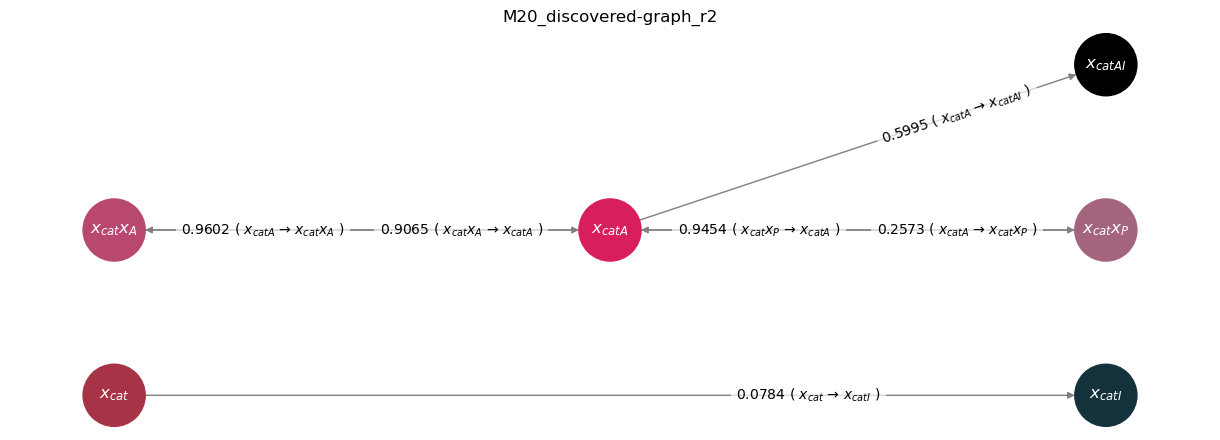

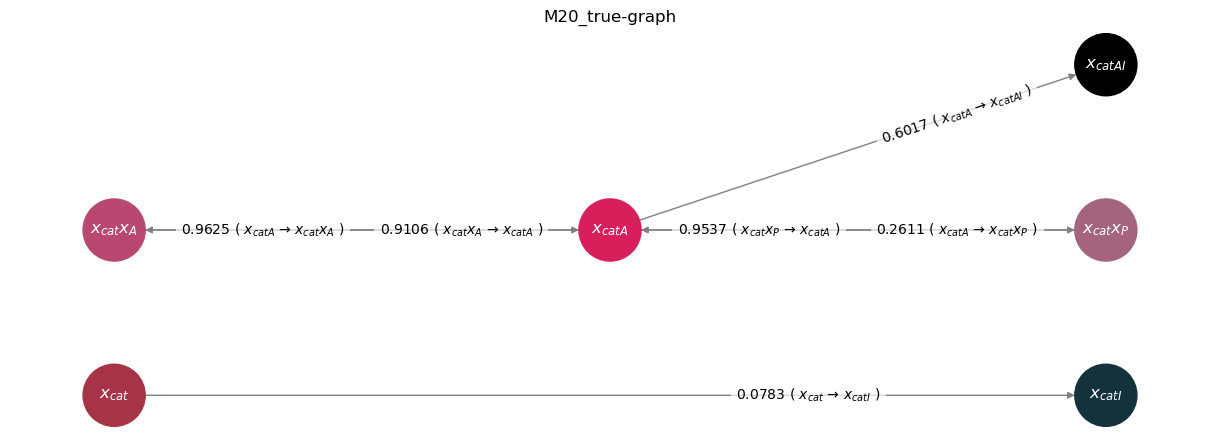

In [16]:
C_int_red2, Q2, Q_labels2 = gs.reduce_model2(C_int,M,N,D_labels)

K_opt2 = gs.solve_kirchhoff(Q2, C_int_red2)
K_opt2 = np.where(np.abs(K_opt2) >= threshold, K_opt2, 0)

#print("The Kirchhoff matrix found by optimization (with zero-complex) is:")

if model == 'VdV':
    graph_labels = ['$x_{1}$', 
                    '$x_{2}$', 
                    '$x_{3}$',
                    '$x_{4}$',
                    '$x_{1}x_{1}$'
                   ]
    
    positions = {'$x_{1}$'      : (0, 0),
                 '$x_{2}$'      : (2, 0.05),
                 '$x_{3}$'      : (1, 0),
                 '$x_{4}$'      : (2, 0),
                 '$x_{1}x_{1}$' : (0, 0.05)
                }
    
    node_colours = {'$x_{1}$'     : np.array(colours[0]), 
                    '$x_{2}$'     : np.array(colours[1]), 
                    '$x_{3}$'     : np.array(colours[2]),
                    '$x_{4}$'     : np.array(colours[3]), 
                    '$x_{1}x_{1}$': np.array(blend(colours[0], colours[0]))
                    }
    size         = (10, 2)


if model == 'M20':
    graph_labels = ['$x_{A}$',
                    '$x_{P}$',
                    '$x_{cat}$',
                    '$x_{catA}$',
                    '$x_{catI}$',
                    '$x_{catAI}$',
                    '$x_{cat}x_{A}$',
                    '$x_{cat}x_{P}$'
                   ]
    
    positions = {'$x_{cat}x_{A}$': (0.0, 0.1),
                 '$x_{catA}$' : (3.0, 0.1),
                 '$x_{cat}x_{P}$': (6.0, 0.1),
                 '$x_{cat}$'  : (0.0, 0.0),
                 '$x_{catI}$' : (6.0, 0.0),
                 '$x_{catAI}$' : (6.0, 0.2)
                 }


    node_colours = {'$x_{cat}$'      : np.array(colours[2]),
                    '$x_{catA}$'     : np.array(colours[3]),
                    '$x_{cat}x_{A}$' : np.array(blend(colours[3], colours[0])),
                    '$x_{cat}x_{P}$' : np.array(blend(colours[3], colours[1])),
                    '$x_{catI}$'     : np.array(colours[4]),
                    '$x_{catAI}$'    : np.array(colours[5])
                    }
    size         = (12, 4)



#print(graph_labels)
#print(Q_labels2)
#print(K_opt2)

gs.draw_directed_graph_from_kirchhoff(-K_opt2.T,
                                      labels       = graph_labels,
                                      title        = model + "_discovered-graph_r2",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

gs.draw_directed_graph_from_kirchhoff(-K_ex.T,
                                      labels       = graph_labels,
                                      title        = model + "_true-graph",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

In [17]:
print('Ground truth ODE')
Eq_ex = symbolic_equations(C_ex, np.asarray(D_labels).T)
print('\n')
print('Model recovery ODE')
Eq_int = symbolic_equations(C_int, np.asarray(D_labels).T)
print('\n')
print('Graph recovery ODE')
Eq_int_K = symbolic_equations(Q2 @ K_opt2, np.array(Q_labels2).T)

Ground truth ODE
Equation 0:
-0.911⋅cat*A + 0.962⋅catA
Equation 1:
-0.954⋅cat*P + 0.261⋅catA
Equation 2:
-0.078⋅cat - 0.911⋅cat*A - 0.954⋅cat*P + 1.224⋅catA
Equation 3:
0.911⋅cat*A + 0.954⋅cat*P - 1.825⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Model recovery ODE
Equation 0:
-0.911⋅cat*A + 0.963⋅catA
Equation 1:
-0.952⋅cat*P + 0.26⋅catA
Equation 2:
-0.079⋅cat - 0.907⋅cat*A - 0.947⋅cat*P + 1.217⋅catA
Equation 3:
0.906⋅cat*A + 0.945⋅cat*P - 1.817⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.602⋅catA


Graph recovery ODE
Equation 0:
-0.912⋅cat*A + 0.96⋅catA
Equation 1:
-0.954⋅cat*P + 0.257⋅catA
Equation 2:
-0.079⋅cat - 0.912⋅cat*A - 0.954⋅cat*P + 1.217⋅catA
Equation 3:
0.906⋅cat*A + 0.945⋅cat*P - 1.819⋅catA
Equation 4:
0.078⋅cat
Equation 5:
0.599⋅catA
